In [19]:
import sys
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
from matplotlib import cm

sys.path.insert(1, '/Users/andrewroberts/Desktop/git-repos/gp-calibration/python')
from helper_functions import get_bounds, scale_inputs, gen_extrapolation_test_inputs
from vsem import *

In [20]:
RANDOM_SEED = 10
rng = np.random.default_rng(RANDOM_SEED)

In [21]:
# Setup. 

# Number of time steps (days) to simulate model. 
n_year = 3
n_time_step = 365*n_year

# Parameters to calibrate. 
par_cal_names = ["KEXT", "LUE"]

## Latex macros

$$
\newcommand{\state}{x}
\newcommand{\Time}{t}
\newcommand{\timeIdx}{k}
\newcommand{\indexTime}[2][\timeIdx]{{#2}_{#1}}
\newcommand{\firstTimeIdxState}{0}
\newcommand{\firstTimeIdxObs}{1}
\newcommand{\timeInitState}{\indexTime[\firstTimeIdxState]{\Time}}
\newcommand{\timeInitObs}{\indexTime[\firstTimeIdxObs]{\Time}}
\newcommand{\stateInit}{\state_{\firstTimeIdxState}}
\newcommand{\stateInitObs}{\state_{\firstTimeIdxObs}}
\newcommand{\stateApprox}{\hat{\state}}
\newcommand{\timeEnd}{T}
\newcommand{\Ntime}{K} % Number of time steps 
\newcommand{\lastTimeIdx}{\Ntime} % May or may not be equal to \Ntime depending on whether indexing starts from one or zero, etc. 
\newcommand{\timeStep}{h}
\newcommand{\funcODE}{f}
\newcommand{\forcing}{w}
\newcommand{\stateTime}[1][\timeIdx]{\indexTime[{#1}]{\state}}
\newcommand{\forcingTime}[1][\timeIdx]{\indexTime[{#1}]{\forcing}}
\newcommand{\fwdOne}{g} % One-step forward operator (flow map) 
\newcommand{\dimState}{P}
\newcommand{\stateIdx}{p}
\newcommand{\indexState}[2][\stateIdx]{{#2}^{(#1)}}
\newcommand{\stateV}{\state_{\text{v}}}
\newcommand{\stateR}{\state_{\text{r}}}
\newcommand{\stateS}{\state_{\text{s}}}
\newcommand{\dstateV}{\dot{\state}_{\text{v}}}
\newcommand{\dstateR}{\dot{\state}_{\text{r}}}
\newcommand{\dstateS}{\dot{\state}_{\text{s}}}
\newcommand{\NPP}{\textrm{NPP}}
\newcommand{\GPP}{\textrm{GPP}}
\newcommand{\alphaV}{\alpha_{\text{v}}}
\newcommand{\tauV}{\tau_{\text{v}}}
\newcommand{\tauR}{\tau_{\text{r}}}
\newcommand{\tauS}{\tau_{\text{s}}}
\newcommand{\LUE}{\ell}
\newcommand{\LAR}{r}
\newcommand{\KEXT}{\kappa}
\newcommand{\fracRespiration}{\gamma}
\newcommand{\LAI}{\textrm{LAI}}
$$

# The Very Simple Ecosystem Model (VSEM) 


## State Equations 
$$
\begin{align}
\dstateV(\Time) &= \alphaV \NPP(\stateV(\Time), \forcing(\Time)) - \frac{\stateV(\Time)}{\tauV} \\
\dstateR(\Time) &= (1.0 - \alphaV) \NPP(\stateV(\Time), \forcing(\Time)) - \frac{\stateR(\Time)}{\tauR} \nonumber \\ 
\dstateS(\Time) &= \frac{\stateR(\Time)}{\tauR} + \frac{\stateV(\Time)}{\tauV} - \frac{\stateS(\Time)}{\tauS}
\end{align}
$$

## Model Driver
$$
\begin{align}
\NPP(\stateV, \forcing) &= (1 - \fracRespiration) \GPP(\stateV, \forcing) \\
\GPP(\stateV, \forcing) &= \forcing \cdot \LUE \cdot \left[1 - \exp\left\{-\KEXT \cdot \LAI(\stateV) \right\} \right] \\
\LAI(\stateV) &= \LAR \cdot \stateV.
\end{align} 
$$

In [22]:
# VSEM Defaults.
par_default = get_vsem_default_pars()
print(par_default)
par_default = par_default["value"].values
print(par_default)

   par_name      value
0      KEXT      0.500
1       LAR      1.500
2       LUE      0.002
3     GAMMA      0.400
4      tauV   1440.000
5      tauS  27370.000
6      tauR   1440.000
7        Av      0.500
8        Cv      3.000
9        Cs     15.000
10       Cr      3.000
[5.000e-01 1.500e+00 2.000e-03 4.000e-01 1.440e+03 2.737e+04 1.440e+03
 5.000e-01 3.000e+00 1.500e+01 3.000e+00]


In [23]:
# Choose Calibration parameters and define priors. 
par_prior = get_vsem_default_priors()
par_cal_idx = np.where(par_prior.par_name.isin(par_cal_names))[0]
par_cal_prior = np.take(par_prior, par_cal_idx, axis=0)
dim_par = len(par_cal_names)
par_cal_prior

,par_name,dist,param1,param2
0,KEXT,Uniform,0.2000,1.000
2,LUE,Uniform,0.0005,0.004


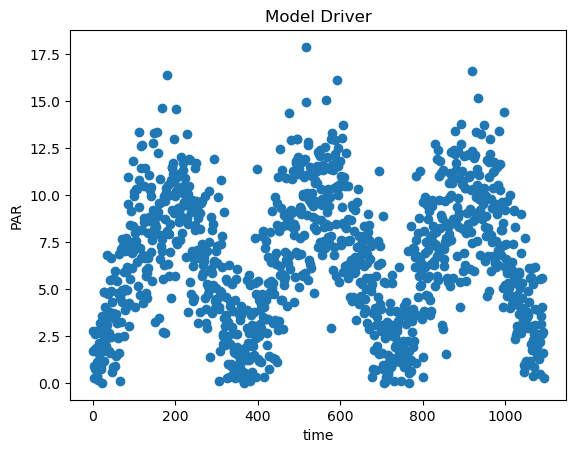

In [24]:
# Forcing/driving data: photosynthetically active radiation. 
# Note that time t here is in days, so t=1 is 1 day and t=365 is 1 year. 
time_steps, model_driver = get_PAR_driver(n_time_step, rng=rng)
plt.plot(time_steps, model_driver, "o")
plt.xlabel("time")
plt.ylabel("PAR")
plt.title("Model Driver")
plt.show()

In [25]:
# Define the observation operator. For convenience, this is broken down in to the 
# composition of a deterministic component and a noise component, but a more complex
# noise model could also be considered. The input to these functions will be the output
# from the function `fwd()` defined above. This will typically be a matrix of shape 
# (number time steps, number output variables).

# def obs_op_annual_mean(fwd_model_output):
#    # This creates annual averages; only works if the number of rows in 
#    # `fwd_model_output` is divisible by 365. 
#    veg_idx = output_names.index("Cv")
#    fwd_model_output = fwd_model_output[:,veg_idx,np.newaxis]
#    n_output = fwd_model_output.shape[1]
#    return fwd_model_output.reshape((-1,365,n_output)).mean(axis=1)

output_names = get_vsem_output_names()
veg_idx = output_names.index("Cv")

# Forward model. 
fwd = get_vsem_fwd_model(model_driver, dim_par, par_cal_idx, par_default, simplify=False)

def obs_op(pred_fwd):
    # The output variable is assumed to be stored in the last dimension. This 
    # accounts for the case where `fwd` is of dimension (N_time_step, N_output)
    # (as in a single model run) or (N_run, N_time_step, N_output) (as in the 
    # case of output from multiple runs). 
    return np.take(pred_fwd, veg_idx, axis=-1)

def param_to_obs_op(par):
    return obs_op(fwd(par))    

In [26]:
# Generate ground truth data and observed data.
signal_to_noise_ratio = 20
par_true = par_default.copy()
par_cal_true = par_true[par_cal_idx]
fwd_true = fwd(par_cal_true)
y_true = obs_op(fwd_true)
sig_eps =  np.mean(y_true) / signal_to_noise_ratio
eps = sp.stats.norm(loc=0, scale=np.sqrt(sig_eps))
y_obs = y_true + eps.rvs(size=y_true.shape, random_state=rng)

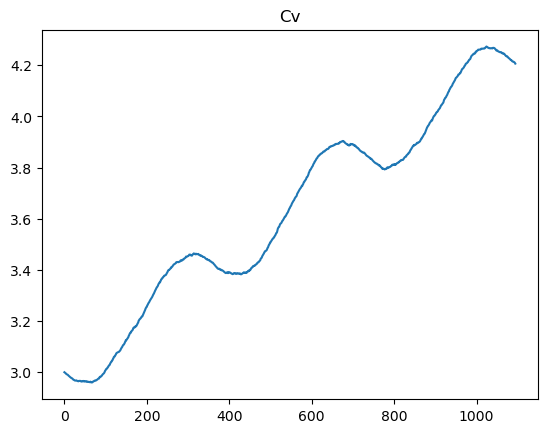

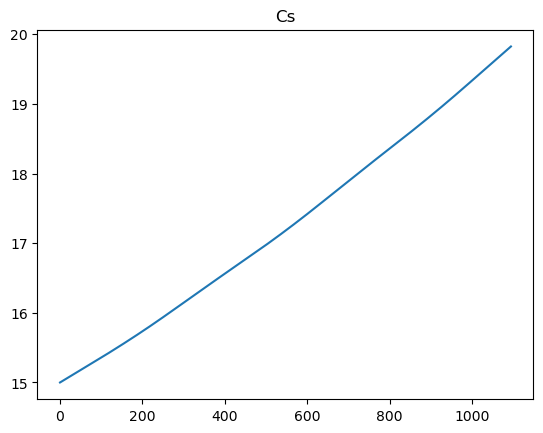

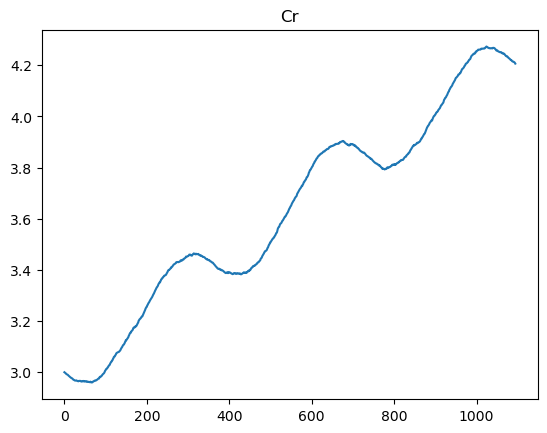

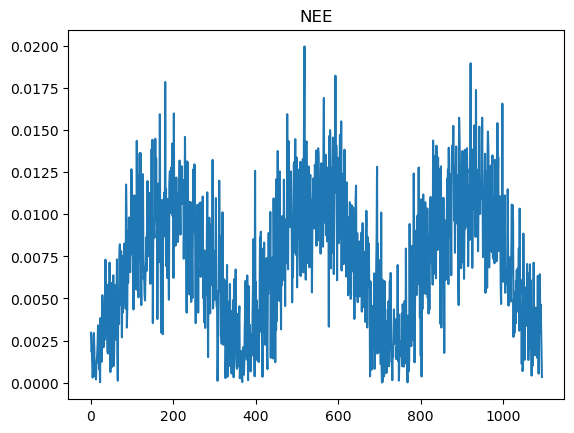

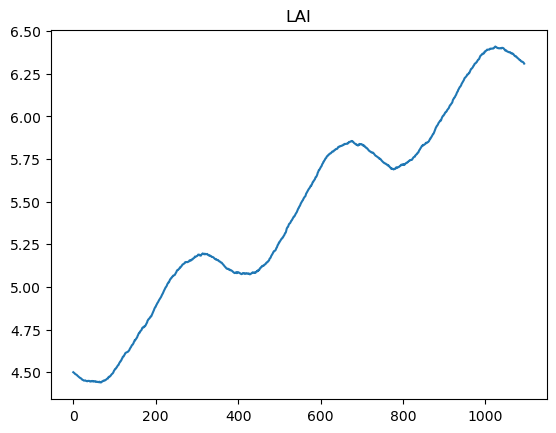

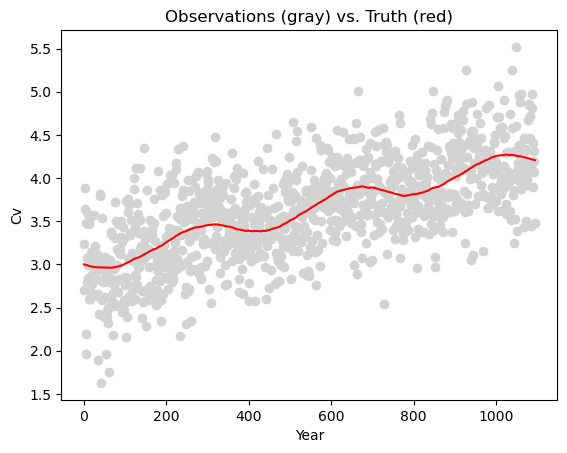

In [27]:
# Model Projections. 
for j in range(fwd_true.shape[2]):
    plt.plot(time_steps, fwd_true[0,:,j])
    plt.title(output_names[j])
    plt.show()

# Observations.
plt.plot(time_steps, y_obs.T, marker="o", linestyle="", color="lightgray")
plt.plot(time_steps, y_true.T, color="red")
plt.title("Observations (gray) vs. Truth (red)")
plt.xlabel("Year")
plt.ylabel("Cv")
plt.show()

# Log Prior, Exact Likelihood, and Posterior Density Functions

In [28]:
prior = []
for i in range(dim_par):
    loc = par_cal_prior.param1.values[i]
    scale = par_cal_prior.param2.values[i] - loc
    prior.append(sp.stats.uniform(loc=loc, scale=scale))

In [29]:
def calc_llik(par, y, pred_fwd=None, pred_obs=None):
    # The observations `y` are assume to be of dimension (1,N_time_step). 
    # `param_to_obs_op()` returns array of shape (N_run, N_time_step).
    # This function returns an array of shape (N_run,) containing the 
    # log-likelihood evaluations at each parameter value. 

    # Compute the observable predicted by the model. 
    if pred_obs is None:
        if pred_fwd is None:
            pred_obs = param_to_obs_op(par)
        else:
            pred_obs = obs_op(pred_fwd)
            
    # Evaluate log-likelihood. 
    return eps.logpdf(y-pred_obs).sum(axis=1)

def calc_lprior(par):
    # `par` assumed to be either shape (N_par,) for log prior evaluation at single 
    # point or (N_points, N_par) for prior evaluation at `N_points` points. 
    if par.ndim == 1:
        par = par.reshape((1,-1))
    return np.array([prior[i].logpdf(par[:,i]) for i in range(dim_par)]).sum(axis=0)

def calc_lpost(par, pred_fwd=None, pred_obs=None, llik=None, lprior=None, y=None): 

    # Evaluate log-likelihood. 
    if llik is None:
        llik = calc_llik(par, y, pred_fwd, pred_obs)

    # Evaluate log-prior. 
    if lprior is None:
        lprior = calc_lprior(par)

    return lprior+llik

# Design and Test Points 

In [30]:
# Generate design points based on prior distribution. 
# TODO: for now this is particular to 2d param space, need to generalize. 
n_design = 10
lh_sampler = sp.stats.qmc.LatinHypercube(d=dim_par)
uniform_design = lh_sampler.random(n=n_design)
par_cal_design = np.hstack((prior[0].ppf(uniform_design[:,0]).reshape((n_design,1)), 
                            prior[1].ppf(uniform_design[:,1]).reshape((n_design,1))))

In [31]:
# Generate grid of test points. 
n_grid_1d = 50
grid_bounds = np.asarray(par_cal_prior[["param1", "param2"]]).T
x1_grid = np.linspace(grid_bounds[0,0], grid_bounds[1,0], num=n_grid_1d)
x2_grid = np.linspace(grid_bounds[0,1], grid_bounds[1,1], num=n_grid_1d)
x_grid = np.meshgrid(x1_grid, x2_grid)
par_cal_test = np.array([(x1, x2) for x1 in x1_grid for x2 in x2_grid])
n_test = par_cal_test.shape[0]

In [54]:
# Create extrapolation points to test emulator tail behavior. 
n_extrap_points_per_dim = 50
max_extrap_scale = 2
par_design_bounds = get_bounds(par_cal_design)
design_extrap = gen_extrapolation_test_inputs(dim_par, n_extrap_points_per_dim, 
                                              max_scaler=max_extrap_scale, target_bounds=par_design_bounds)
design_extrap_long = design_extrap.reshape((design_extrap.shape[0] * design_extrap.shape[1], 2))
llik_extrap = calc_llik(design_extrap_long, y_obs)

In [33]:
# Generate llik responses at design and test points.
fwd_design = fwd(par_cal_design)

pred_obs_design = obs_op(fwd_design)
pred_obs_test = param_to_obs_op(par_cal_test)

llik_design = calc_llik(par_cal_design, y_obs, pred_obs=pred_obs_design)
llik_test = calc_llik(par_cal_test, y_obs, pred_obs=pred_obs_test)

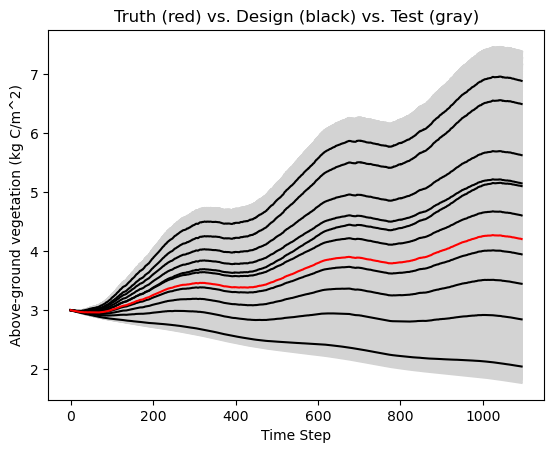

In [34]:
# Plot simulated observables vs. ground truth.
plt.plot(time_steps, pred_obs_test.T, color="lightgray")
plt.plot(time_steps, pred_obs_design.T, color="k")
plt.plot(time_steps, y_true.T, color="red")
plt.xlabel("Time Step")
plt.ylabel("Above-ground vegetation (kg C/m^2)")
plt.title("Truth (red) vs. Design (black) vs. Test (gray)")
plt.show()

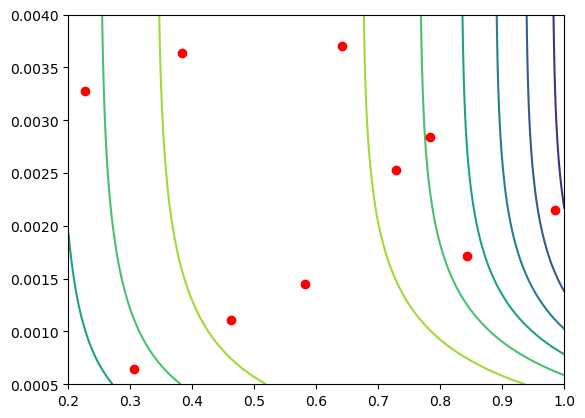

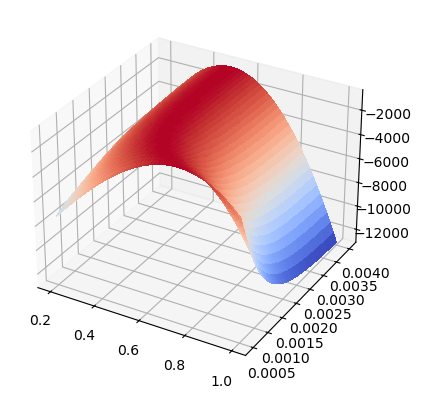

In [37]:
# Contour plot. 
plt.contour(x_grid[0], x_grid[1], llik_test.reshape(n_grid_1d, n_grid_1d))
plt.plot(par_cal_design[:,0], par_cal_design[:,1], "or")
plt.show()

# 3d surface plot. 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X=x_grid[0], Y=x_grid[1], Z=llik_test.reshape(n_grid_1d, n_grid_1d), cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

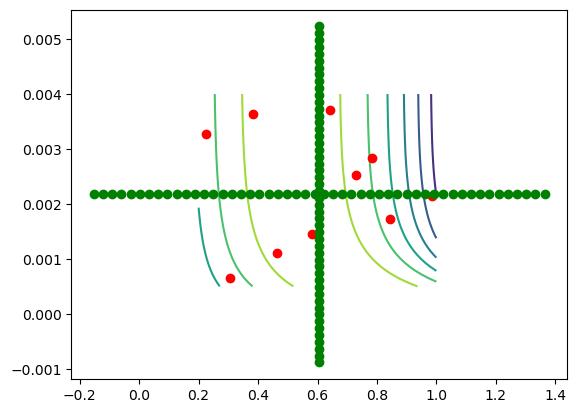

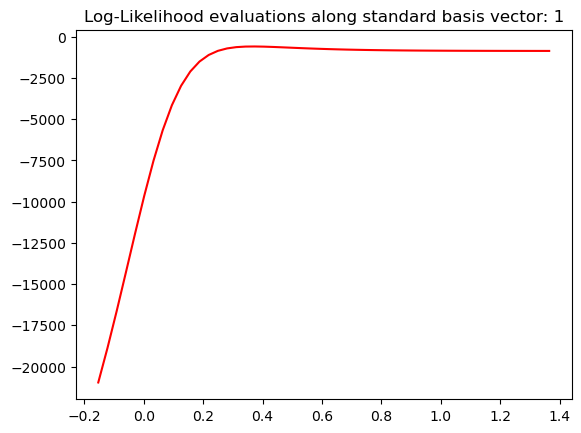

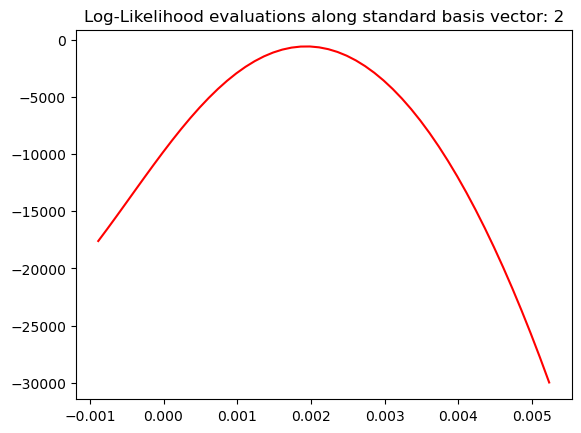

In [55]:
# Contour plot with extrapolation points. 
plt.contour(x_grid[0], x_grid[1], llik_test.reshape(n_grid_1d, n_grid_1d))
plt.plot(par_cal_design[:,0], par_cal_design[:,1], "or")
plt.plot(design_extrap_long[:,0], design_extrap_long[:,1], "og")
plt.show()

# Plot log-likelihood at extrapolation points along each coordinate axis. 
for j in range(dim_par):
    start_idx = 0 + j*n_extrap_points_per_dim
    stop_idx = (j+1) * n_extrap_points_per_dim
    plt.plot(design_extrap_long[start_idx:stop_idx,j], llik_extrap[start_idx:stop_idx], "r")
    plt.title("Log-Likelihood evaluations along standard basis vector: "+str(j+1))
    plt.show()

In [43]:
# TODO: the dimensions in the above extrapolation plots seem flipped. -> Check scaling function. 
# TODO: scale inputs to [0,1]^d. 

(100,)